In [1]:
# https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pulsar').getOrCreate()

from pyspark.sql.functions import isnan, when, count, col, udf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df_train = spark.read.csv("/FileStore/tables/pulsar_data_train.csv", header=True, inferSchema=True)
df_test = spark.read.csv("/FileStore/tables/pulsar_data_test.csv", header=True, inferSchema=True)

In [3]:
df_train.printSchema()

root
-- Mean of the integrated profile: double (nullable = true)
-- Standard deviation of the integrated profile: double (nullable = true)
-- Excess kurtosis of the integrated profile: double (nullable = true)
-- Skewness of the integrated profile: double (nullable = true)
-- Mean of the DM-SNR curve: double (nullable = true)
-- Standard deviation of the DM-SNR curve: double (nullable = true)
-- Excess kurtosis of the DM-SNR curve: double (nullable = true)
-- Skewness of the DM-SNR curve: double (nullable = true)
-- target_class: double (nullable = true)

In [4]:
df_train.take(1)

Out[4]: [Row( Mean of the integrated profile=121.15625, Standard deviation of the integrated profile=48.37297113, Excess kurtosis of the integrated profile=0.375484665, Skewness of the integrated profile=-0.013165488999999999, Mean of the DM-SNR curve=3.168896321, Standard deviation of the DM-SNR curve=18.399366600000004, Excess kurtosis of the DM-SNR curve=7.449874148999999, Skewness of the DM-SNR curve=65.15929771, target_class=0.0)]

In [5]:
df_test.printSchema()

root
-- Mean of the integrated profile: double (nullable = true)
-- Standard deviation of the integrated profile: double (nullable = true)
-- Excess kurtosis of the integrated profile: double (nullable = true)
-- Skewness of the integrated profile: double (nullable = true)
-- Mean of the DM-SNR curve: double (nullable = true)
-- Standard deviation of the DM-SNR curve: double (nullable = true)
-- Excess kurtosis of the DM-SNR curve: double (nullable = true)
-- Skewness of the DM-SNR curve: double (nullable = true)
-- target_class: string (nullable = true)

In [6]:
df_test.take(1)

Out[6]: [Row( Mean of the integrated profile=116.90625, Standard deviation of the integrated profile=48.92060492, Excess kurtosis of the integrated profile=0.18604632100000001, Skewness of the integrated profile=-0.129815137, Mean of the DM-SNR curve=3.037625418, Standard deviation of the DM-SNR curve=17.73710156, Excess kurtosis of the DM-SNR curve=8.122620787, Skewness of the DM-SNR curve=78.81340454, target_class=None)]

In [7]:
print('Train: Rows: {}, Columns: {}'.format(df_train.count(), len(df_train.columns)))
print('Test: Rows: {}, Columns: {}'.format(df_test.count(), len(df_test.columns)))

Train: Rows: 12528, Columns: 9
Test: Rows: 5370, Columns: 9

In [8]:
df_test.groupby('target_class').count().show()

+------------+-----+
target_class|count|
+------------+-----+
 null| 5370|
+------------+-----+

In [9]:
df_test = df_test.drop('target_class')

In [10]:
df_test.persist()

Out[10]: DataFrame[ Mean of the integrated profile: double, Standard deviation of the integrated profile: double, Excess kurtosis of the integrated profile: double, Skewness of the integrated profile: double, Mean of the DM-SNR curve: double, Standard deviation of the DM-SNR curve: double, Excess kurtosis of the DM-SNR curve: double, Skewness of the DM-SNR curve: double]

In [11]:
df_train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_train.columns]).collect()

Out[11]: [Row( Mean of the integrated profile=0, Standard deviation of the integrated profile=0, Excess kurtosis of the integrated profile=1735, Skewness of the integrated profile=0, Mean of the DM-SNR curve=0, Standard deviation of the DM-SNR curve=1178, Excess kurtosis of the DM-SNR curve=0, Skewness of the DM-SNR curve=625, target_class=0)]

In [12]:
df_test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_test.columns]).collect()

Out[12]: [Row( Mean of the integrated profile=0, Standard deviation of the integrated profile=0, Excess kurtosis of the integrated profile=767, Skewness of the integrated profile=0, Mean of the DM-SNR curve=0, Standard deviation of the DM-SNR curve=524, Excess kurtosis of the DM-SNR curve=0, Skewness of the DM-SNR curve=244)]

In [13]:
df_train = df_train.na.drop()
df_test = df_test.na.drop()

print('Train: Rows: {}, Columns: {}'.format(df_train.count(), len(df_train.columns)))
print('Test: Rows: {}, Columns: {}'.format(df_test.count(), len(df_test.columns)))

Train: Rows: 9273, Columns: 9
Test: Rows: 3985, Columns: 8

In [14]:
df_train.limit(5).toPandas()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0
4,109.406250,55.912521,0.565106,0.056247,2.797659,19.496527,9.443282,97.374578,0.0


In [15]:
df_train.select(' Mean of the integrated profile', ' Standard deviation of the integrated profile').summary().show()

+-------+-------------------------------+---------------------------------------------+
summary| Mean of the integrated profile| Standard deviation of the integrated profile|
+-------+-------------------------------+---------------------------------------------+
 count| 9273| 9273|
 mean| 111.13375020219993| 46.514052911853746|
 stddev| 25.68640537915268| 6.781319578562155|
 min| 6.1875| 24.77204176|
 25%| 100.984375| 42.39838208|
 50%| 115.234375| 46.89502632|
 75%| 189.734375| 91.8086279|
 max| 189.734375| 91.8086279|
+-------+-------------------------------+---------------------------------------------+

In [16]:
df_train.groupBy('target_class').count().show()

+------------+-----+
target_class|count|
+------------+-----+
 0.0| 8423|
 1.0| 850|
+------------+-----+

In [17]:
df_train.groupBy('target_class').mean(' Mean of the integrated profile', ' Mean of the DM-SNR curve').show()

+------------+------------------------------------+------------------------------+
target_class|avg( Mean of the integrated profile)|avg( Mean of the DM-SNR curve)|
+------------+------------------------------------+------------------------------+
 0.0| 116.64799878309391| 8.886565869002865|
 1.0| 56.49079044117647| 50.874638009127025|
+------------+------------------------------------+------------------------------+

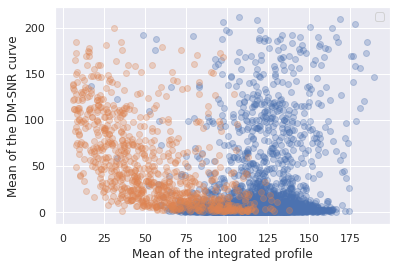

In [18]:
plt.scatter(
  df_train.where(df_train.target_class == 0).select(' Mean of the integrated profile').toPandas(), 
  df_train.where(df_train.target_class == 0).select(' Mean of the DM-SNR curve').toPandas(),
  alpha = 0.3
)

plt.scatter(
  df_train.where(df_train.target_class == 1).select(' Mean of the integrated profile').toPandas(), 
  df_train.where(df_train.target_class == 1).select(' Mean of the DM-SNR curve').toPandas(),
  alpha = 0.3
)

plt.xlabel('Mean of the integrated profile')
plt.ylabel('Mean of the DM-SNR curve')
plt.legend()

In [19]:
litterate_target = udf(lambda x: 'pulsar' if x == 1 else 'not_pulsar')
df_train = df_train.withColumn('literate_target', litterate_target('target_class'))
df_train.head()

Out[19]: Row( Mean of the integrated profile=121.15625, Standard deviation of the integrated profile=48.37297113, Excess kurtosis of the integrated profile=0.375484665, Skewness of the integrated profile=-0.013165488999999999, Mean of the DM-SNR curve=3.168896321, Standard deviation of the DM-SNR curve=18.399366600000004, Excess kurtosis of the DM-SNR curve=7.449874148999999, Skewness of the DM-SNR curve=65.15929771, target_class=0.0, literate_target='not_pulsar')

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [21]:
df_train.columns[:-2]

Out[21]: [' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve']

In [22]:
df_test.columns[:]

Out[22]: [' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve']

In [23]:
assembler = VectorAssembler(inputCols=df_train.columns[:-2], outputCol='features')
assembler.transform(df_train).select('features','target_class').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------+------------+
features |target_class|
+----------------------------------------------------------------------------------------------------------------------+------------+
[121.15625,48.37297113,0.375484665,-0.013165488999999999,3.168896321,18.399366600000004,7.449874148999999,65.15929771]|0.0 |
[76.96875,36.17555664,0.71289786,3.3887185630000003,2.399665552,17.57099693,9.414652256,102.7229747] |0.0 |
[130.5859375,53.22953353,0.133408289,-0.297241641,2.743311037,22.36255299,8.508363784,74.03132420000001] |0.0 |
[84.8046875,36.11765898,0.825012787,3.274125373,2.7901337789999996,20.61800857,8.405008383,76.29112787] |0.0 |
[109.40625,55.91252061,0.565105947,0.056246664,2.797658863,19.49652729,9.443282129,97.37457842] |0.0 |
+----------------------------------------------------------------------------------------------------------------------+------------+
only showing top 5 rows

In [24]:
evaluator = MulticlassClassificationEvaluator(labelCol='target_class', metricName='accuracy')

In [25]:
rf = RandomForestClassifier(labelCol='target_class')

pipeline_rf = Pipeline(stages=[assembler, rf])

paramGrid = ParamGridBuilder().\
            addGrid(rf.maxDepth, [3, 5, 10]).\
            addGrid(rf.minInfoGain, [0.1]).\
            addGrid(rf.numTrees, [200]).\
            build()

cv = CrossValidator(
  estimator=pipeline_rf, 
  estimatorParamMaps=paramGrid, 
  evaluator=evaluator, 
  numFolds=5
)

model_final = cv.fit(df_train)
pred_train = model_final.transform(df_train)
evaluator.evaluate(pred_train)

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Out[32]: 0.9674323304216542

In [26]:
from sklearn.metrics import classification_report

pred_train_pd = pred_train.toPandas()
print(classification_report(pred_train_pd.prediction, pred_train_pd.target_class))

precision recall f1-score support

 0.0 1.00 0.97 0.98 8693
 1.0 0.66 0.97 0.79 580

 accuracy 0.97 9273
 macro avg 0.83 0.97 0.89 9273
weighted avg 0.98 0.97 0.97 9273

In [27]:
pred_test = model_final.transform(df_test)

In [28]:
pred_test.printSchema()

root
-- Mean of the integrated profile: double (nullable = true)
-- Standard deviation of the integrated profile: double (nullable = true)
-- Excess kurtosis of the integrated profile: double (nullable = true)
-- Skewness of the integrated profile: double (nullable = true)
-- Mean of the DM-SNR curve: double (nullable = true)
-- Standard deviation of the DM-SNR curve: double (nullable = true)
-- Excess kurtosis of the DM-SNR curve: double (nullable = true)
-- Skewness of the DM-SNR curve: double (nullable = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [29]:
pred_test.select('probability','prediction').show(10, truncate=False)

+----------------------------------------+----------+
probability |prediction|
+----------------------------------------+----------+
[0.960317598567806,0.03968240143219398] |0.0 |
[0.47506386814837187,0.5249361318516281]|1.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.6110211038876231,0.38897889611237685]|0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
[0.960317598567806,0.03968240143219398] |0.0 |
+----------------------------------------+----------+
only showing top 10 rows